In [5]:
%pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from time import time 

import spacy
import nltk
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support


In [2]:
df = pd.read_csv('./custom_data.csv')
df.dropna(inplace=True)

In [3]:
df.shape

(1074, 3)

In [4]:
Y = df['field']

In [5]:
Y.head

<bound method NDFrame.head of 0       frontend development
1       frontend development
2       frontend development
3       frontend development
4       frontend development
                ...         
1257       machine learning 
1258       machine learning 
1259       machine learning 
1260       machine learning 
1261       machine learning 
Name: field, Length: 1074, dtype: object>

cloud engineer          219
cyber security          219
backend development     215
machine learning        211
frontend development    210
Name: field, dtype: int64
Shape of dataset: (1074, 3)


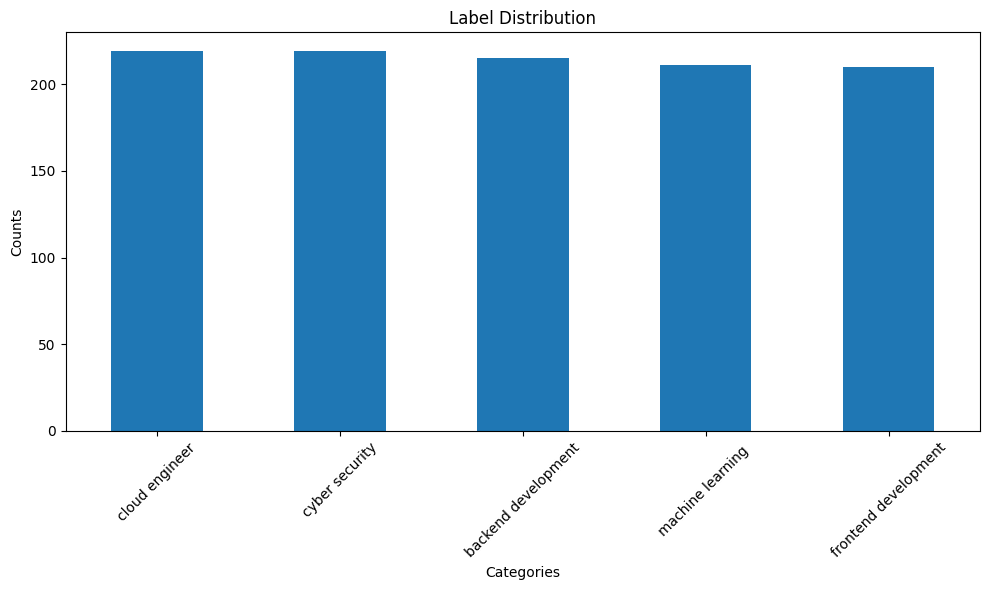

In [6]:
label_counts = Y.value_counts()
print(label_counts)
print(f"Shape of dataset: {df.shape}")
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')

# Add labels and a title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Label Distribution')

# Show the graph
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [7]:
nlp = spacy.load('en_core_web_sm')
# nltk.download('wordnet')

stopwords = _stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

print(df['description'][0])

Wrote re-useable test documents to ensure 100% code coverage


In [8]:
clean(df['description'][0])

'wrote useable test documents ensure code coverage'

In [9]:
print(df['description'])

0       Wrote re-useable test documents to ensure 100%...
1       Wrote re-useable test documents to ensure 100%...
2       Developed automated homepage and connected pag...
3       Created robust filter functionality, along wit...
4       Developed secure authentication and multiple w...
                              ...                        
1257    Successfully engineered solutions to big data ...
1258    Developed a machine learning algorithm that in...
1259    Trained a neural network to achieve 90% accura...
1260    Implemented a support vector machine that achi...
1261    Designed and implemented an unsupervised learn...
Name: description, Length: 1074, dtype: object


In [10]:
df['description'] = df['description'].apply(clean)

In [11]:
docs = list(df['description'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

print(docs)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
print(docs[0].size)

2224


In [20]:
X = docs 
y = df['field']
print(X.shape, y.shape)

(1074, 2224) (1074,)


In [21]:
y

0       3
1       3
2       3
3       3
4       3
       ..
1257    4
1258    4
1259    4
1260    4
1261    4
Name: field, Length: 1074, dtype: int32

In [22]:
LE = LabelEncoder()
df=df.apply(LE.fit_transform) 

In [23]:
class_mapping = dict(zip(LE.classes_, range(len(LE.classes_))))
print("Mapping from numerical labels to original class labels:")
print(class_mapping)

Mapping from numerical labels to original class labels:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [24]:
x = df.drop('field', axis=1)
y = df['field']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"xtrain shape: {xtrain.shape}")
print(f"ytrain shape: {ytrain.shape}")
print(f"xtest shape: {xtest.shape}")
print(f"ytest shape: {ytest.shape}")

xtrain shape: (751, 2)
ytrain shape: (751,)
xtest shape: (323, 2)
ytest shape: (323,)


In [25]:
counter = Counter(ytrain)

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)

counter = Counter(ytrain)

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("Upsampled data shape: ", xtrain.shape, ytrain.shape)

Class= 0, n=152 (20.24%)
Class= 2, n=152 (20.24%)
Class= 1, n=152 (20.24%)
Class= 4, n=141 (18.77%)
Class= 3, n=154 (20.51%)
Class= 0, n=154 (20.00%)
Class= 2, n=154 (20.00%)
Class= 1, n=154 (20.00%)
Class= 4, n=154 (20.00%)
Class= 3, n=154 (20.00%)
Upsampled data shape:  (770, 2) (770,)


In [26]:
scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [27]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
def baseline_model():
    # create model
    model = Sequential()

    # Add L2 regularization to reduce overfitting
    model.add(Dense(16, input_dim=2224, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(8, input_dim=2224, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))

    # Softmax for multi-class classification
    model.add(Dense(5, activation='softmax'))

    # Compile model without early stopping callback
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

    return model

In [28]:
cmodel = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)

g:\project 3\product\server\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [29]:
SEED=80
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(966, 2224) (966,)
(108, 2224) (108,)


In [30]:
ytrain_encoded = to_categorical(ytrain)

print(f"The ytrain encoded shape: {ytrain_encoded.shape}")
print(f"ytrain encoded: \n{ytrain_encoded}")

The ytrain encoded shape: (966, 5)
ytrain encoded: 
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [31]:
model = baseline_model() 
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
%time history = model.fit(xtrain, ytrain_encoded, validation_split=0.2, epochs=200, batch_size=100, verbose=0, callbacks=[early_stopping])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [32]:
ytest_encoded = to_categorical(ytest)
_, accuracy = model.evaluate(xtest, ytest_encoded)
print('Accuracy from evaluate: %.2f' % (accuracy*100)+"%")

4/4 [==============================] - 0s 0s/step - loss: 0.8905 - accuracy: 0.7222
Accuracy from evaluate: 72.22%


In [33]:
import pickle
sum_accuracy = 0
max_accuracy = -1
max_precision = -1
max_recall = -1
max_f1_score = -1
iteration_of_max_acc = -1

for i in range(1000):
    SEED=80
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    ytrain_encoded = to_categorical(ytrain)

    model = baseline_model() 
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(xtrain, ytrain_encoded, validation_split=0.2, epochs=200, batch_size=100, verbose=0, callbacks=[early_stopping])
    ytest_encoded = to_categorical(ytest)
    _, accuracy = model.evaluate(xtest, ytest_encoded)

    y_pred_prob = model.predict(xtest)
    y_pred = np.argmax(y_pred_prob, axis=1)
    ytest_classes = np.argmax(ytest_encoded, axis=1)

    precision, recall, f1_score, _ = precision_recall_fscore_support(ytest_classes, y_pred, average='weighted')
    
    # print('Accuracy from evaluate: %.2f' % (accuracy*100)+"%" + f" in iteration: {i}\n")
    str1 = 'Accuracy from evaluate: %.2f' % (accuracy*100)+"%" + f" in iteration: {i}\n"
    str2 = f"Precision: {precision:.4f}% \nRecall: {recall:.4f}% \nf1_score: {f1_score:.4f}\n\n"
    with open('log.txt', 'a') as f:
        f.write(str1)
        f.write(str2)

    f.close()
    sum_accuracy = sum_accuracy + (accuracy*100)
    if (accuracy*100) > max_accuracy:
        max_accuracy = (accuracy*100)
        max_precision = precision
        max_recall = recall
        max_f1_score = f1_score
        iteration_of_max_acc = i
    
    filename = f"pickles/model{i}_{accuracy*100}.sav"
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

    
    
    
average_accuracy = sum_accuracy/1000
# print(f"Average accuracy: {average_accuracy}")
# print(f"Max accuracy found at iteration {iteration_of_max_acc} with accuracy of {max_accuracy}")
with open('log.txt', 'a') as f:
    f.write(f"Average accuracy: {average_accuracy}")
    f.write(f"Max accuracy found at iteration {iteration_of_max_acc} with accuracy of {max_accuracy}")
    f.write(f"With Precision: {max_precision}, Recall: {max_recall}, F1 Score: {max_f1_score}")

f.close()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


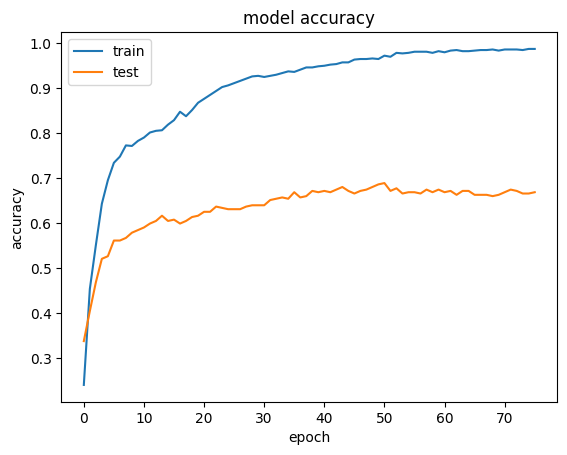

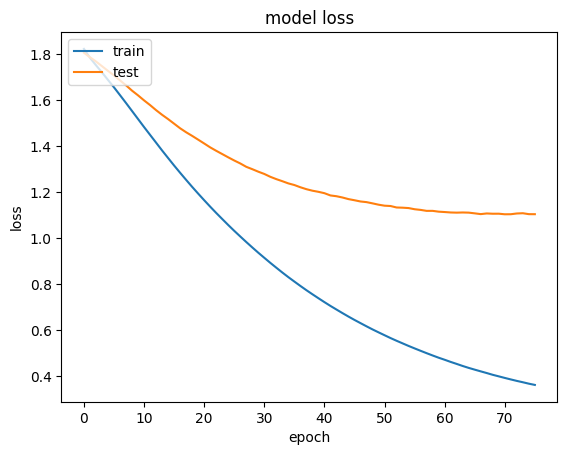

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import h5py

In [38]:
import pickle
filename = 'pickles/finalized_model.sav'
with open(filename, 'wb') as f:
    pickle.dump(model, f)
    
f.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-11-19 09:41:59         1992
metadata.json                                  2023-11-19 09:41:59           64
variables.h5                                   2023-11-19 09:41:59       337784


In [ ]:
!pip show tensorflow

In [ ]:
!pip show keras

In [ ]:
import joblib

data = "Engineered an automated homepage and connected pages system using React.js, with intelligent rendering and styling for 25% reduced development effort."
data = clean(data)
docs = [data]
print(docs)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()
# scaler = MinMaxScaler()
# xtrain = scaler.fit_transform(xtrain)

print(tfidf_vectorizer_vectors.shape)

In [ ]:
tfidf_vectorizer_vectors.shape[1]

In [ ]:
dense_tfidf_vectorizer_vectors = tfidf_vectorizer_vectors.toarray()

# Create reshaped_data with the correct shape
reshaped_data = np.zeros((dense_tfidf_vectorizer_vectors.shape[0], 2510))

# Copy the values from tfidf_vectorizer_vectors to reshaped_data
reshaped_data[:, :dense_tfidf_vectorizer_vectors.shape[1]] = dense_tfidf_vectorizer_vectors

In [ ]:
print(reshaped_data.size)

In [ ]:
model = joblib.load('./pickles_final/model111_796.sav')
predictions = model.predict(reshaped_data)

print(predictions)

In [ ]:
{'backend development': 0, 
'cloud engineer': 1, 
'cyber security': 2, 
'frontend development': 3, 
'machine learning ': 4}